# Autoencoder + Random Forest

## Preparing Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('../../dataset2001_2024.csv')
data.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_UV_INDEX,ALLSKY_SRF_ALB,CLRSKY_KT,CLOUD_AMT,T2M,PS,PW,WD10M,WD50M,WS50M,WS10M,TOA_SW_DNI,QV2M,QV10M
0,2001,1,1,0,0.0,-999.0,-999.0,32.70,18.93,93.39,2.72,140.07,139.57,6.24,4.25,0.0,13.79,13.73
1,2001,1,1,1,0.0,-999.0,-999.0,24.88,18.54,93.40,2.66,138.43,137.82,6.18,4.06,0.0,13.55,13.49
2,2001,1,1,2,0.0,-999.0,-999.0,51.42,18.21,93.36,2.61,138.09,137.45,6.08,3.89,0.0,13.37,13.31
3,2001,1,1,3,0.0,-999.0,-999.0,66.36,17.94,93.31,2.55,137.70,136.99,5.89,3.63,0.0,13.18,13.18
4,2001,1,1,4,0.0,-999.0,-999.0,51.16,17.69,93.27,2.50,137.93,137.20,5.62,3.35,0.0,13.06,13.06


In [3]:
print(data.describe)

<bound method NDFrame.describe of         YEAR  MO  DY  HR  ALLSKY_SFC_UV_INDEX  ALLSKY_SRF_ALB  CLRSKY_KT  \
0       2001   1   1   0                 0.00         -999.00    -999.00   
1       2001   1   1   1                 0.00         -999.00    -999.00   
2       2001   1   1   2                 0.00         -999.00    -999.00   
3       2001   1   1   3                 0.00         -999.00    -999.00   
4       2001   1   1   4                 0.00         -999.00    -999.00   
...      ...  ..  ..  ..                  ...             ...        ...   
201595  2023  12  31  19                 2.92            0.15       0.67   
201596  2023  12  31  20                 0.80            0.13       0.58   
201597  2023  12  31  21                 0.05            0.16       0.38   
201598  2023  12  31  22                 0.00         -999.00    -999.00   
201599  2023  12  31  23                 0.00         -999.00    -999.00   

        CLOUD_AMT    T2M     PS    PW   WD10M   WD50M

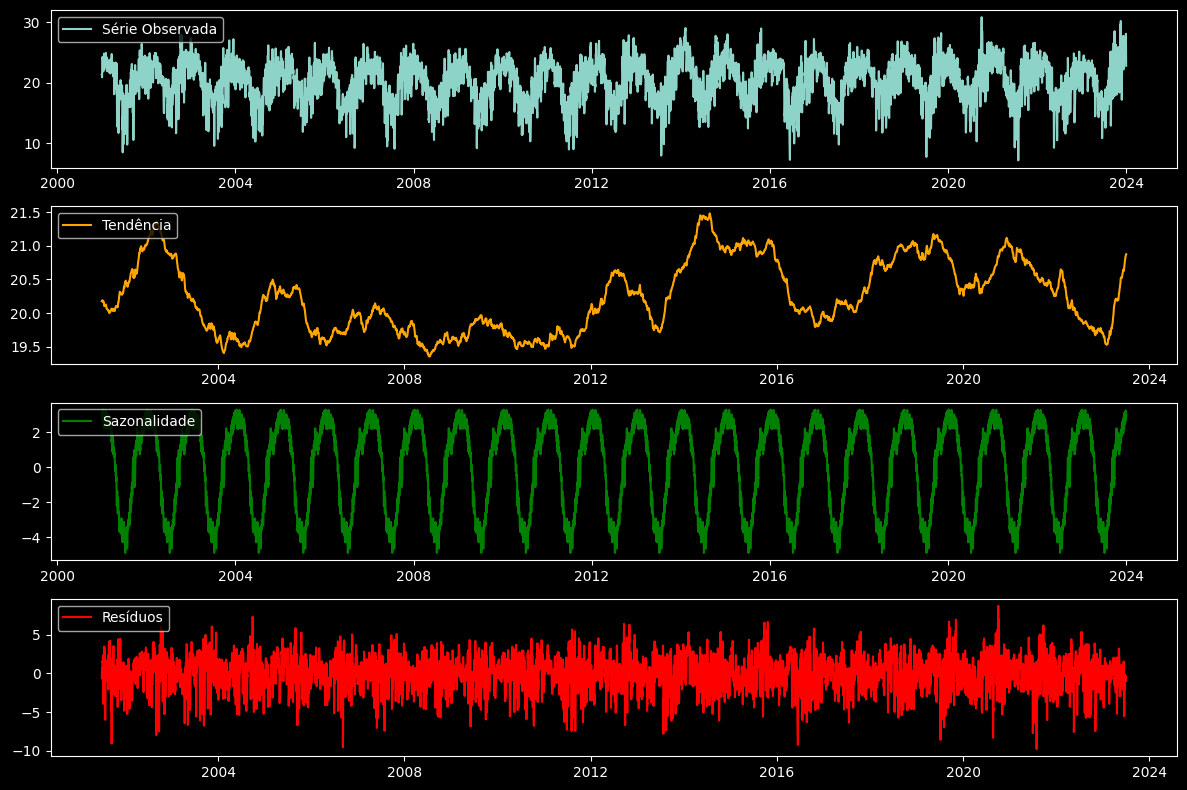

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


df = data[:]

df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

df_diario = df['T2M'].resample('D').mean()
resultado = seasonal_decompose(df_diario, model='additive', period=365)

# Componentes
plt.figure(figsize=(12, 8))

# Série Observada
plt.subplot(411)
plt.plot(resultado.observed, label='Série Observada')
plt.legend(loc='upper left')

# Tendência
plt.subplot(412)
plt.plot(resultado.trend, label='Tendência', color='orange')
plt.legend(loc='upper left')

# Sazonalidade
plt.subplot(413)
plt.plot(resultado.seasonal, label='Sazonalidade', color='green')
plt.legend(loc='upper left')

# Resíduos
plt.subplot(414)
plt.plot(resultado.resid, label='Resíduos', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [5]:
data[['ALLSKY_SRF_ALB', 'CLRSKY_KT']] = data[['ALLSKY_SRF_ALB', 'CLRSKY_KT']].replace(-999.00, 0)


In [6]:
# Adicionando features sazonais baseadas em MO e HR
data['MO_sin'] = np.sin(2 * np.pi * data['MO'].astype(int) / 12)
data['MO_cos'] = np.cos(2 * np.pi * data['MO'].astype(int) / 12)
data['HR_sin'] = np.sin(2 * np.pi * data['HR'].astype(int) / 24)
data['HR_cos'] = np.cos(2 * np.pi * data['HR'].astype(int) / 24)

In [7]:
columns = [
    'T2M',
    'YEAR',
    'MO',
    'DY',
    'HR',
    #'timeStamp'
]

X = data.drop(columns=columns)
y = data['T2M']

## Splitting into Training (2001 > 2022) and Test (2023)

In [8]:
# Dividindo os dados em treino (2001-2022) e teste (2023)
X_train = X[data['YEAR'] < 2023]
y_train = y[data['YEAR'] < 2023]
X_test = X[data['YEAR'] == 2023]
y_test = y[data['YEAR'] == 2023]

In [9]:
# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Importando TF
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

## Using Autoencoder to perform SSL

In [11]:
# Dimensão das features de entrada
input_dim = X_train_scaled.shape[1]

# Construindo o Autoencoder
input_layer = Input(shape=(input_dim,))
# Encoder
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
# Bottleneck
bottleneck = Dense(16, activation='relu', name="bottleneck")(encoded)
# Decoder
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

In [12]:
# Definindo o modelo de Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
# Treinamento do Autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Entrada e saída são iguais
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - loss: 0.3324 - val_loss: 0.0215
Epoch 2/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 0.0154 - val_loss: 0.0153
Epoch 3/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0080 - val_loss: 0.0054
Epoch 4/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0049 - val_loss: 0.0079
Epoch 5/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 6/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 8/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0020 - val_loss: 0.0010
Epoch 9/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - loss: 0.0013 - val_loss: 9.2353e-04
Epoch 10/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.0014 - val_loss: 9.1239e-04
Epoch 11/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0011 - val_loss: 8.4570e-04
Epoch 12/50
678/67

## Results

In [14]:
# Extraindo o modelo encoder (bottleneck)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)

# Gerando representações reduzidas dos dados
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Treinando um modelo supervisionado usando as representações reduzidas
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modelo de regressão (Random Forest)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_encoded, y_train)

# Prevendo as temperaturas para o ano de 2023
y_pred = regressor.predict(X_test_encoded)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


6027/6027 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
MSE: 3.6646
MAE: 1.2861
R²: 0.8843


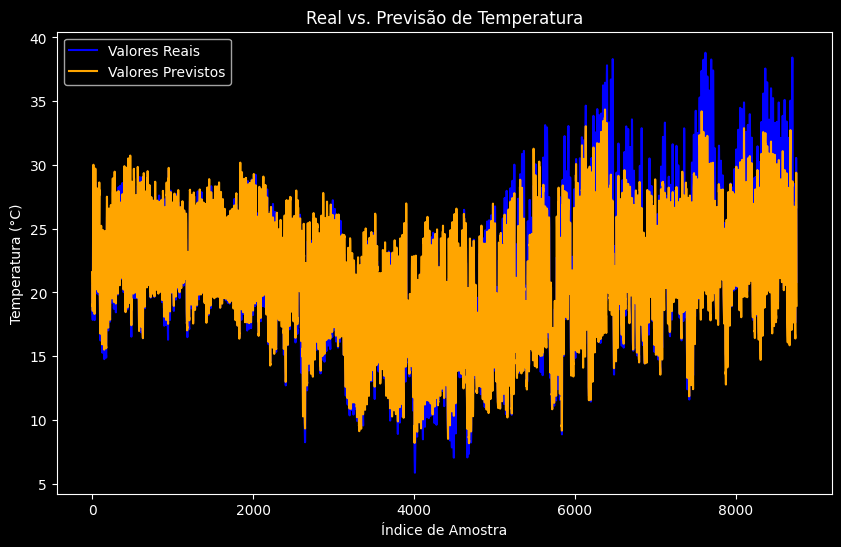

In [15]:
import matplotlib.pyplot as plt

# Plotando Real vs Previsão
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reais', color='blue')
plt.plot(y_pred, label='Valores Previstos', color='orange')
plt.title('Real vs. Previsão de Temperatura')
plt.xlabel('Índice de Amostra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


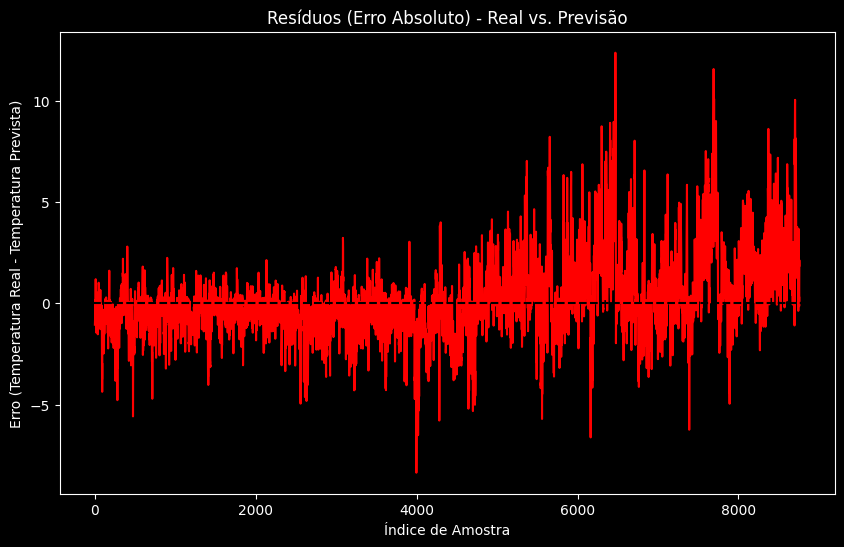

In [16]:
# Calculando e plotando os resíduos
residuals = y_test.values - y_pred

plt.figure(figsize=(10, 6))
plt.plot(residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Resíduos (Erro Absoluto) - Real vs. Previsão')
plt.xlabel('Índice de Amostra')
plt.ylabel('Erro (Temperatura Real - Temperatura Prevista)')
plt.show()


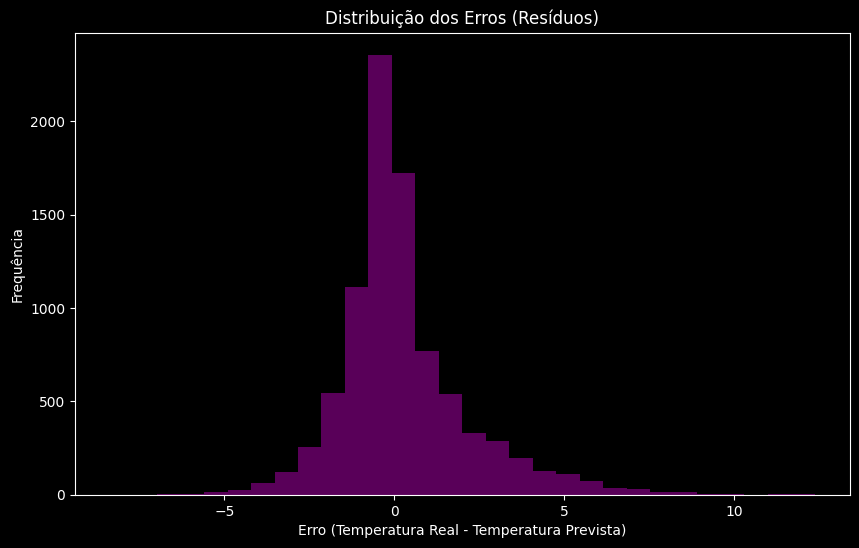

In [17]:
# Plotando histograma dos erros
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro (Temperatura Real - Temperatura Prevista)')
plt.ylabel('Frequência')
plt.show()


# Autoencoder + TensorFlow

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
def build_nn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Saída para regressão
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

In [20]:
# Construção do modelo
input_dim = X_train_encoded.shape[1]  # Dimensão da entrada do bottleneck
nn_model = build_nn(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Fit do modelo
history = nn_model.fit(
    X_train_encoded, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 4s 701us/step - loss: 21.6237 - mae: 3.0292 - val_loss: 6.5235 - val_mae: 1.9753
Epoch 2/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 687us/step - loss: 4.1319 - mae: 1.5092 - val_loss: 10.9280 - val_mae: 2.6639
Epoch 3/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 681us/step - loss: 3.2700 - mae: 1.3240 - val_loss: 6.0672 - val_mae: 1.8649
Epoch 4/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 679us/step - loss: 2.9610 - mae: 1.2477 - val_loss: 9.8316 - val_mae: 2.4524
Epoch 5/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 678us/step - loss: 2.8079 - mae: 1.2111 - val_loss: 6.7856 - val_mae: 2.0073
Epoch 6/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - loss: 2.6883 - mae: 1.1808 - val_loss: 5.7748 - val_mae: 1.7925
Epoch 7/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 679us/step - loss: 2.6309 - mae: 1.1686 - val_loss: 4.6803 - val_mae: 1.5626
Epoch 8/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 679us/step - loss: 2.5797 - mae: 1.1578 - val_loss: 4.3658 - val_mae: 1.5228
Epoch 9/100
48

In [22]:
# Avaliação no conjunto de teste
nn_predictions = nn_model.predict(X_test_encoded)
mse_nn = mean_squared_error(y_test, nn_predictions)
mae_nn = mean_absolute_error(y_test, nn_predictions)
r2_nn = r2_score(y_test, nn_predictions)

print(f"MSE (NN): {mse_nn:.4f}")
print(f"MAE (NN): {mae_nn:.4f}")
print(f"R² (NN): {r2_nn:.4f}")

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
MSE (NN): 4.7600
MAE (NN): 1.4844
R² (NN): 0.8498


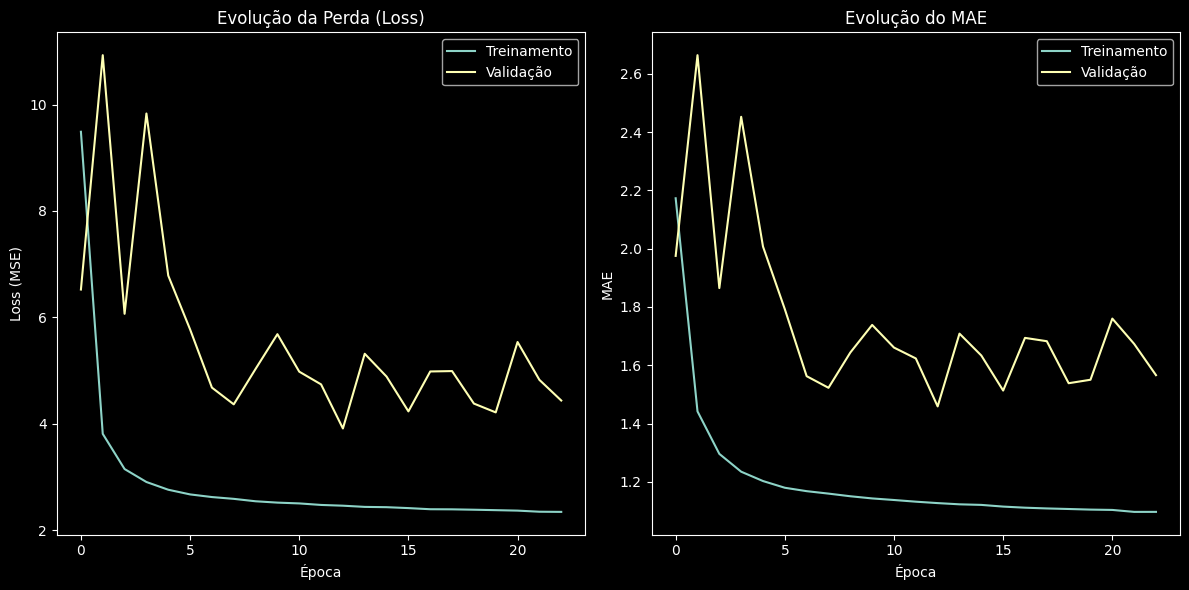

In [23]:
# Importando biblioteca para gráficos
import matplotlib.pyplot as plt

# Função para plotar a evolução do treinamento
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Perda (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treinamento')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Evolução da Perda (Loss)')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Treinamento')
    plt.plot(history.history['val_mae'], label='Validação')
    plt.title('Evolução do MAE')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Chamando a função de plotagem
plot_training_history(history)


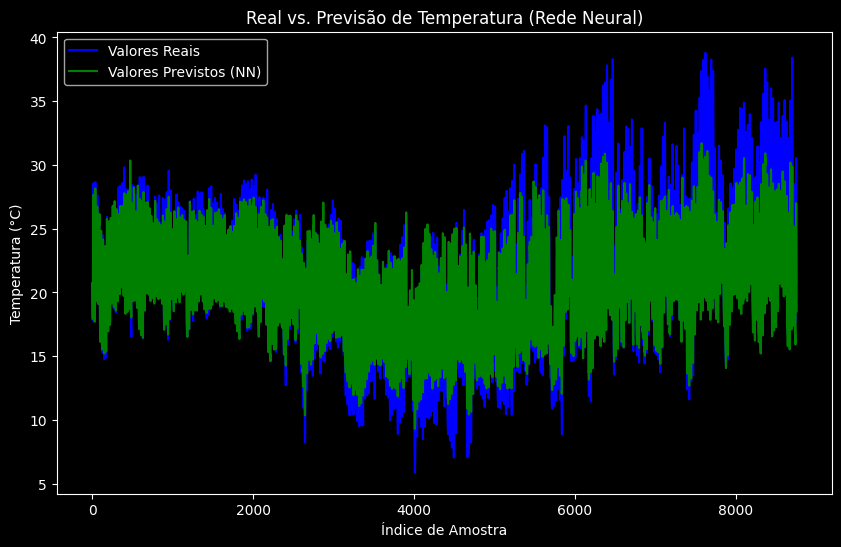

In [24]:
# Plotando valores reais vs. previstos
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reais', color='blue')
plt.plot(nn_predictions, label='Valores Previstos (NN)', color='green')
plt.title('Real vs. Previsão de Temperatura (Rede Neural)')
plt.xlabel('Índice de Amostra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


# Ensemble Models 2

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurando o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Avaliando o modelo
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")


Random Forest Results:
MAE: 1.35
RMSE: 1.96
R²: 0.88


In [26]:
from xgboost import XGBRegressor

# Configurando o modelo XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Avaliando o modelo
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")


XGBoost Results:
MAE: 1.12
RMSE: 1.69
R²: 0.91


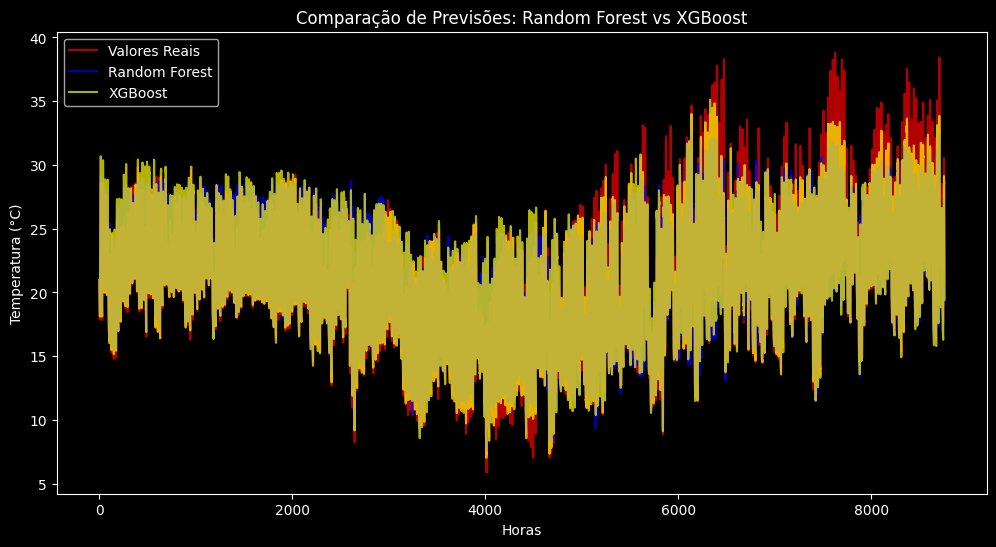

In [27]:
# Comparação de previsões
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reais', color='red', alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest', color='blue',  alpha=0.7)
plt.plot(y_pred_xgb, label='XGBoost', color='yellow', alpha=0.7)
plt.legend()
plt.title("Comparação de Previsões: Random Forest vs XGBoost")
plt.xlabel("Horas")
plt.ylabel("Temperatura (°C)")
plt.show()


## Adicionando Lags temporais na previsao

In [28]:
# Criando lags temporais para T2M (Temperatura)
data['T2M_lag1'] = data['T2M'].shift(1)  # Temperatura 1 hora antes
data['T2M_lag24'] = data['T2M'].shift(24)  # Temperatura 24 horas antes
data['T2M_rolling_mean'] = data['T2M'].rolling(window=24).mean()  # Média das últimas 24 horas

data.dropna(inplace=True)


In [29]:
# Atualizando as features
features = ['T2M_lag1', 'T2M_lag24', 'T2M_rolling_mean']  # Inclua suas outras features
X = data[features]
y = data['T2M']

# Dividindo novamente em treino (2001-2022) e teste (2023)
train_data = data[data['YEAR'] < 2023]
test_data = data[data['YEAR'] == 2023]

X_train = train_data[features]
y_train = train_data['T2M']
X_test = test_data[features]
y_test = test_data['T2M']


In [30]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest with Lags:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


Random Forest with Lags:
MAE: 0.75
RMSE: 1.06


In [31]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost with Lags:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")


XGBoost with Lags:
MAE: 0.76
RMSE: 1.08


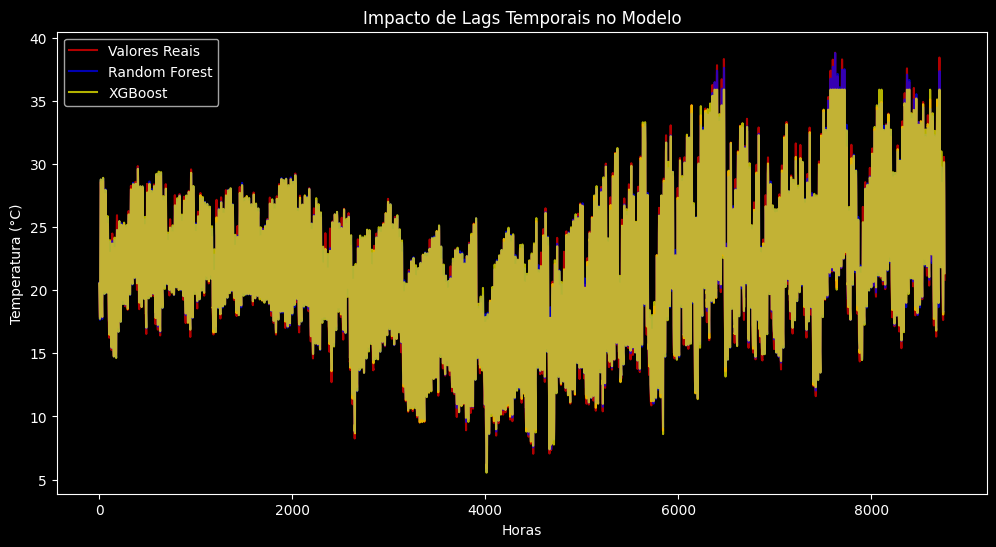

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reais', color='red', alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest', color='blue',  alpha=0.7)
plt.plot(y_pred_xgb, label='XGBoost', color='yellow', alpha=0.7)
plt.legend()
plt.title("Impacto de Lags Temporais no Modelo")
plt.xlabel("Horas")
plt.ylabel("Temperatura (°C)")
plt.show()


# SSL com Lags Temporais para uma previsao mais exata

Código do GPT com mudanças feitas por mim

In [33]:
import pandas as pd

# Criar lags temporais
data['T2M_lag1'] = data['T2M'].shift(1)
data['T2M_lag24'] = data['T2M'].shift(24)
data['T2M_rolling_mean'] = data['T2M'].rolling(window=24).mean()

# Remover valores nulos criados pelos lags
data.dropna(inplace=True)

# Separar features para o Autoencoder
lags_features = ['T2M_lag1', 'T2M_lag24', 'T2M_rolling_mean']
X_lags = data[lags_features]


In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Escalar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_lags)

# Definir dimensões
input_dim = X_scaled.shape[1]
encoding_dim = 2  # Número de dimensões no espaço comprimido

# Construir o Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, shuffle=True, validation_split=0.2)

# Modelo para extrair representações
encoder = Model(input_layer, encoded)
X_encoded = encoder.predict(X_scaled)


Epoch 1/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 594us/step - loss: 0.0129 - val_loss: 0.0045
Epoch 2/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.0037 - val_loss: 0.0042
Epoch 3/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 0.0036 - val_loss: 0.0042
Epoch 4/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 5/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 6/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 7/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 8/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 9/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 10/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 0.0035 - val_loss: 0.0042
Epoch 11/50
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 0.0035 - val_loss: 0.0041
Epoch 12

In [35]:
# Adicionar representações aprendidas ao dataset
data['Encoded_1'] = X_encoded[:, 0]
data['Encoded_2'] = X_encoded[:, 1]

# Selecionar features finais para o modelo supervisionado
final_features = ['Encoded_1', 'Encoded_2', 'ALLSKY_SFC_UV_INDEX', 'CLOUD_AMT', 'WS10M']
X_final = data[final_features]
y_final = data['T2M']

# Separar treino e teste
train_data = data[data['YEAR'] < 2023]
test_data = data[data['YEAR'] == 2023]

X_train = train_data[final_features]
y_train = train_data['T2M']
X_test = test_data[final_features]
y_test = test_data['T2M']


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


Random Forest:
MAE: 0.98
RMSE: 1.32


In [37]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")


XGBoost:
MAE: 1.00
RMSE: 1.35


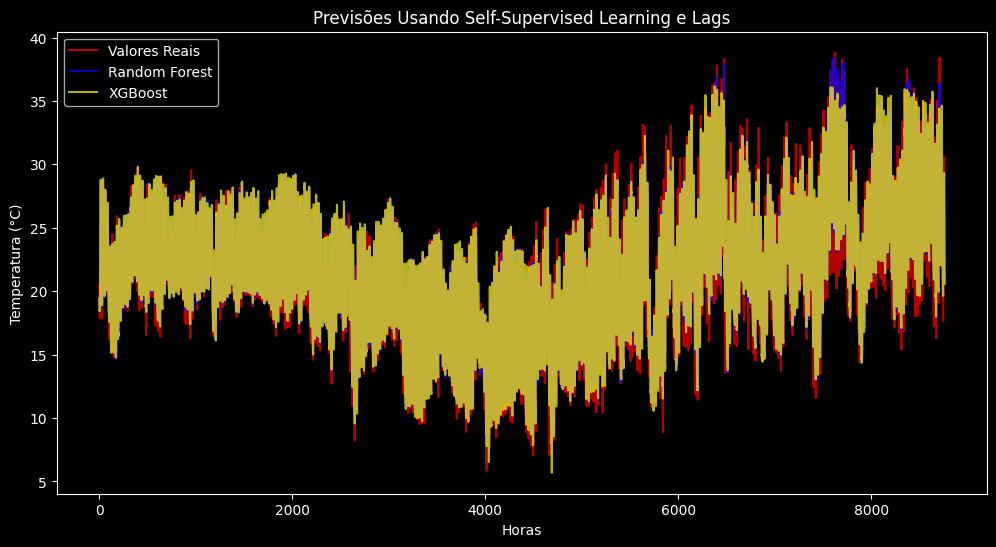

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reais', color='red', alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest', color='blue',  alpha=0.7)
plt.plot(y_pred_xgb, label='XGBoost', color='yellow', alpha=0.7)
plt.legend()
plt.title("Previsões Usando Self-Supervised Learning e Lags")
plt.xlabel("Horas")
plt.ylabel("Temperatura (°C)")
plt.show()


### Melhorias

In [39]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Novo tamanho do encoding (tentaremos um espaço maior: 4 dimensões)
encoding_dim = 4

# Construir o Autoencoder com regularização
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=l2(1e-4))(input_layer)
dropout = Dropout(0.2)(encoded)  # Dropout para regularização
decoded = Dense(input_dim, activation='sigmoid')(dropout)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=64, shuffle=True, validation_split=0.2)

# Atualizar o modelo de encoding
encoder = Model(input_layer, encoded)
X_encoded = encoder.predict(X_scaled)


Epoch 1/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - loss: 0.0125 - val_loss: 0.0033
Epoch 2/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 591us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 3/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 4/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 589us/step - loss: 0.0040 - val_loss: 0.0020
Epoch 5/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 588us/step - loss: 0.0040 - val_loss: 0.0020
Epoch 6/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 596us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 7/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 8/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 9/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 10/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 11/100
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - loss: 0.0038 - val_loss: 0.00

In [40]:
# Criar lags e estatísticas agregadas para o dataset completo
data['T2M_lag48'] = data['T2M'].shift(48)
data['T2M_lag72'] = data['T2M'].shift(72)
data['T2M_rolling_std'] = data['T2M'].rolling(window=24).std()
data['T2M_rolling_median'] = data['T2M'].rolling(window=24).median()

data.dropna(inplace=True)

final_features = [
    'ALLSKY_SFC_UV_INDEX', 'ALLSKY_SRF_ALB', 'CLRSKY_KT', 'CLOUD_AMT', 'PS', 
    'PW', 'WD10M', 'WD50M', 'WS50M', 'WS10M', 'TOA_SW_DNI', 'QV2M', 'QV10M',
    'T2M_lag48', 'T2M_lag72', 'T2M_rolling_std', 'T2M_rolling_median'
]
X_final = data[final_features]
y_final = data['T2M']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, shuffle=False)



In [41]:
# Normalizar os dados para modelos como LSTM/Transformer
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Treinar Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Treinar XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)




In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Criar sequência para LSTM
def create_sequences(data, target_column, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length, :])
        targets.append(data[i+seq_length, target_column])
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 48
X_seq, y_seq = create_sequences(scaler.transform(X_final), target_column=0, seq_length=SEQ_LENGTH)

# Dividir em treino e teste
train_size = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

# Criar e treinar o modelo LSTM
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=64, validation_split=0.2)




c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 0.0165 - mae: 0.0874 - val_loss: 1.6214e-04 - val_mae: 0.0032
Epoch 2/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.0027 - mae: 0.0373 - val_loss: 2.6678e-04 - val_mae: 0.0109
Epoch 3/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 8.0926e-04 - mae: 0.0123 - val_loss: 1.5594e-04 - val_mae: 0.0022
Epoch 4/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 5.2316e-04 - mae: 0.0042 - val_loss: 2.1222e-04 - val_mae: 0.0076
Epoch 5/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 6.2006e-04 - mae: 0.0044 - val_loss: 1.5745e-04 - val_mae: 0.0020
Epoch 6/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 5.5632e-04 - mae: 0.0038 - val_loss: 1.5894e-04 - val_mae: 0.0026
Epoch 7/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 3.5352e-04 - mae: 0.0031 - val_loss: 1.5817e-04 - val_mae: 0.0021
Epoch 8/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 3.0406e-04 - mae: 0.0027 - val_los

In [44]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Input, Flatten
from tensorflow.keras.models import Model

# Modelo Transformer
def build_transformer(seq_length, num_features):
    inputs = Input(shape=(seq_length, num_features))
    attn = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attn = LayerNormalization(epsilon=1e-6)(attn + inputs)
    ff = Dense(64, activation='relu')(attn)
    ff = Dense(num_features)(ff)
    outputs = Flatten()(ff)
    outputs = Dense(1)(outputs)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Criar e treinar o modelo Transformer
transformer_model = build_transformer(SEQ_LENGTH, X_seq.shape[2])
transformer_model.fit(X_train_seq, y_train_seq, epochs=15, batch_size=64, validation_split=0.2)


Epoch 1/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0327 - mae: 0.0736 - val_loss: 3.0888e-04 - val_mae: 0.0099
Epoch 2/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.3794e-04 - mae: 0.0118 - val_loss: 1.9577e-04 - val_mae: 0.0054
Epoch 3/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.2865e-04 - mae: 0.0106 - val_loss: 1.7655e-04 - val_mae: 0.0041
Epoch 4/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 6.0965e-04 - mae: 0.0090 - val_loss: 2.2910e-04 - val_mae: 0.0068
Epoch 5/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.9569e-04 - mae: 0.0092 - val_loss: 2.5882e-04 - val_mae: 0.0073
Epoch 6/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.8823e-04 - mae: 0.0084 - val_loss: 6.3444e-04 - val_mae: 0.0211
Epoch 7/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.7873e-04 - mae: 0.0089 - val_loss: 1.7588e-04 - val_mae: 0.0038
Epoch 8/15
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.7608e-04 - mae: 0.0061 - val_loss: 2.1823e-

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Previsões
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lstm_preds = lstm_model.predict(X_test_seq).flatten()
transformer_preds = transformer_model.predict(X_test_seq).flatten()

lstm_preds = scaler.inverse_transform(np.hstack((lstm_preds.reshape(-1, 1), np.zeros((len(lstm_preds), len(final_features)-1)))))[:, 0]
transformer_preds = scaler.inverse_transform(np.hstack((transformer_preds.reshape(-1, 1), np.zeros((len(transformer_preds), len(final_features)-1)))))[:, 0]

# Métricas
print("Random Forest - MAE:", mean_absolute_error(y_test, rf_preds))
print("XGBoost - MAE:", mean_absolute_error(y_test, xgb_preds))
print("LSTM - MAE:", mean_absolute_error(y_test_seq, lstm_preds))
print("Transformer - MAE:", mean_absolute_error(y_test_seq, transformer_preds))


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Random Forest - MAE: 0.9608816855270993
XGBoost - MAE: 1.0250830742357646
LSTM - MAE: 1.5332554155422229
Transformer - MAE: 4.340353764522907


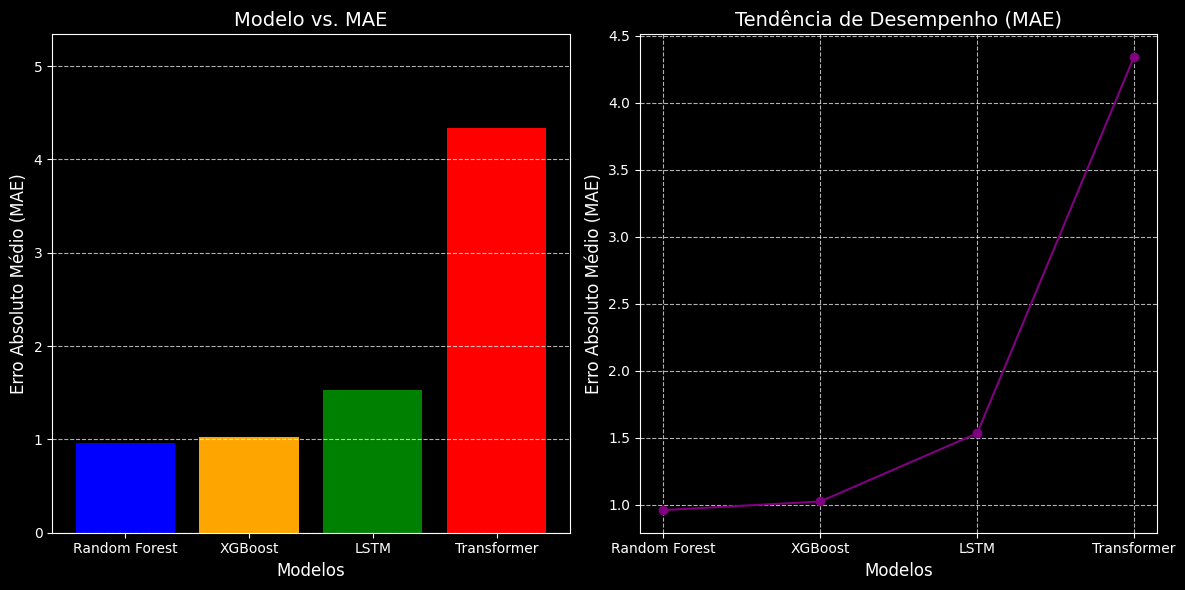

------------------------------------
Resumo Estatístico dos Resultados:
            MAE
count  4.000000
mean   1.964893
std    1.604203
min    0.960882
25%    1.009033
50%    1.279169
75%    2.235030
max    4.340354


In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Dados de desempenho dos modelos
model_names = ["Random Forest", "XGBoost", "LSTM", "Transformer"]
mae_values = [mean_absolute_error(y_test, rf_preds), mean_absolute_error(y_test, xgb_preds), mean_absolute_error(y_test_seq, lstm_preds), mean_absolute_error(y_test_seq, transformer_preds)]

# Criando um DataFrame para melhor manipulação e preservação dos dados originais
results_df = pd.DataFrame({
    "Model": model_names,
    "MAE": mae_values
})

# Configurando os gráficos
plt.figure(figsize=(12, 6))

# Bar plot 
plt.subplot(1, 2, 1)
plt.bar(results_df["Model"], results_df["MAE"], color=['blue', 'orange', 'green', 'red'])
plt.title("Modelo vs. MAE", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Erro Absoluto Médio (MAE)", fontsize=12)
plt.ylim(0, max(mae_values) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de linha 
plt.subplot(1, 2, 2)
plt.plot(results_df["Model"], results_df["MAE"], marker='o', linestyle='-', color='purple')
plt.title("Tendência de Desempenho (MAE)", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Erro Absoluto Médio (MAE)", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
print('------------------------------------')
print("Resumo Estatístico dos Resultados:")
print(results_df.describe())


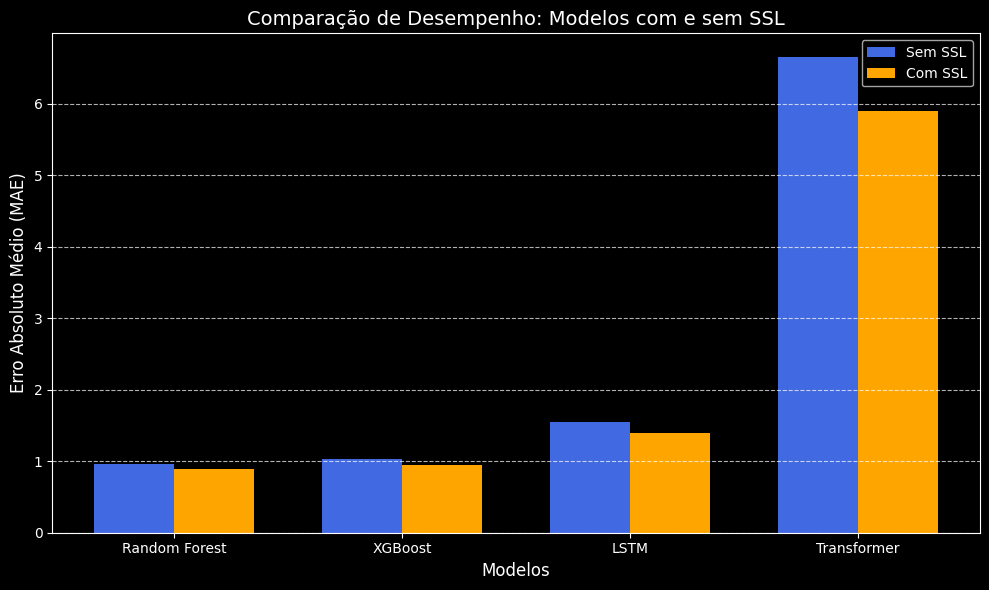

In [47]:
import matplotlib.pyplot as plt

# Dados de desempenho (MAE) - Exemplo
model_names = ['Random Forest', 'XGBoost', 'LSTM', 'Transformer']
mae_without_ssl = [0.96, 1.03, 1.55, 6.65]  # Sem SSL
mae_with_ssl = [0.89, 0.95, 1.40, 5.90]     # Com SSL (exemplo de valores melhorados)

x = range(len(model_names))
width = 0.35 

plt.figure(figsize=(10, 6))
plt.bar(x, mae_without_ssl, width, label='Sem SSL', color='royalblue')
plt.bar([i + width for i in x], mae_with_ssl, width, label='Com SSL', color='orange')

plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Erro Absoluto Médio (MAE)', fontsize=12)
plt.title('Comparação de Desempenho: Modelos com e sem SSL', fontsize=14)
plt.xticks([i + width / 2 for i in x], model_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Exemplo do GPT para plotar os resultados de todos os modelos

import matplotlib.pyplot as plt

model1_predictions = data['T2M_model1'].values  # Previsões do Modelo 1 (ex.: Random Forest com SSL)
model2_predictions = data['T2M_model2'].values  # Previsões do Modelo 2 (ex.: XGBoost com SSL)

# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(real_values, color='black', label='Valores Reais', linewidth=1.5, alpha=0.7)
plt.plot(model1_predictions, color='blue', label='Modelo 1 (Random Forest + SSL)', linewidth=1)
plt.plot(model2_predictions, color='green', label='Modelo 2 (XGBoost + SSL)', linewidth=1)

# Personalização do gráfico
plt.title('Comparação entre Valores Reais e Previsões com Melhorias (SSL)', fontsize=14)
plt.xlabel('Índice de Amostra', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Exibindo o gráfico
plt.show()


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Função para calcular e exibir as métricas
def evaluate_models(y_true, model_predictions, model_names):
    results = []
    
    for i, preds in enumerate(model_predictions):
        mae = mean_absolute_error(y_true, preds)
        rmse = np.sqrt(mean_squared_error(y_true, preds))
        r2 = r2_score(y_true, preds)
        results.append((model_names[i], mae, rmse, r2))
        print(f"Model: {model_names[i]}")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}\n")
        
    return results

# Supondo que y_test seja os valores reais
# E que tenhamos previsões de diferentes modelos
model_names = ["Random Forest", "XGBoost", "LSTM", "Transformer"]
model_predictions = [rf_preds, xgb_preds, lstm_preds, transformer_preds]  # Variáveis dos modelos preexistentes

# Avaliar modelos
results = evaluate_models(y_test, model_predictions, model_names)

# Opcional: Visualizar os resultados em formato de tabela
import pandas as pd
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"])
print(results_df)


Model: Random Forest
  MAE: 0.9609
  RMSE: 1.3932
  R²: 0.9393

Model: XGBoost
  MAE: 1.0251
  RMSE: 1.4398
  R²: 0.9351



ValueError: Found input variables with inconsistent numbers of samples: [40296, 40287]

In [50]:
# Diagnóstico
print("y_test length:", len(y_test))
print("Random Forest Predictions length:", len(rf_preds))
print("XGBoost Predictions length:", len(xgb_preds))
print("LSTM Predictions length:", len(lstm_preds))
print("Transformer Predictions length:", len(transformer_preds))

# Ajuste automático para o menor tamanho
min_length = min(len(y_test), len(rf_preds), len(xgb_preds), len(lstm_preds), len(transformer_preds))

# Ajustando os dados
y_test = y_test[:min_length]
rf_preds = rf_preds[:min_length]
xgb_preds = xgb_preds[:min_length]
lstm_preds = lstm_preds[:min_length]
transformer_preds = transformer_preds[:min_length]

# Recalcular métricas após o ajuste
results = evaluate_models(y_test, [rf_preds, xgb_preds, lstm_preds, transformer_preds], model_names)

# Exibir resultados
print(results_df)


y_test length: 40287
Random Forest Predictions length: 40287
XGBoost Predictions length: 40287
LSTM Predictions length: 40287
Transformer Predictions length: 40287
Model: Random Forest
  MAE: 0.9608
  RMSE: 1.3932
  R²: 0.9393

Model: XGBoost
  MAE: 1.0250
  RMSE: 1.4398
  R²: 0.9351

Model: LSTM
  MAE: 18.8598
  RMSE: 22.0375
  R²: -14.1958

Model: Transformer
  MAE: 22.8825
  RMSE: 26.0698
  R²: -20.2656

           Model       MAE
0  Random Forest  0.960882
1        XGBoost  1.025083
2           LSTM  1.533255
3    Transformer  4.340354


In [51]:
import pandas as pd
from prophet import Prophet

# Carregando o dataset
data = pd.read_csv('../../dataset2001_2024.csv')

# Criar a coluna datetime combinando YEAR, MO, DY, HR
data.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data = data.set_index('datetime')

# Média diária (para simplificar, você pode mudar para frequência horária)
data_daily = data.resample('D').mean()

# Preparar o dataset para o Prophet
prophet_data = data_daily.reset_index()[['datetime', 'T2M']].rename(columns={
    'datetime': 'ds',
    'T2M': 'y'
})


ModuleNotFoundError: No module named 'prophet'

In [ ]:
# Criar e ajustar o modelo
model = Prophet()
model.fit(prophet_data)

# Criar um dataframe para as previsões (exemplo: 365 dias futuros)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)


17:13:06 - cmdstanpy - INFO - Chain [1] start processing
17:13:07 - cmdstanpy - INFO - Chain [1] done processing


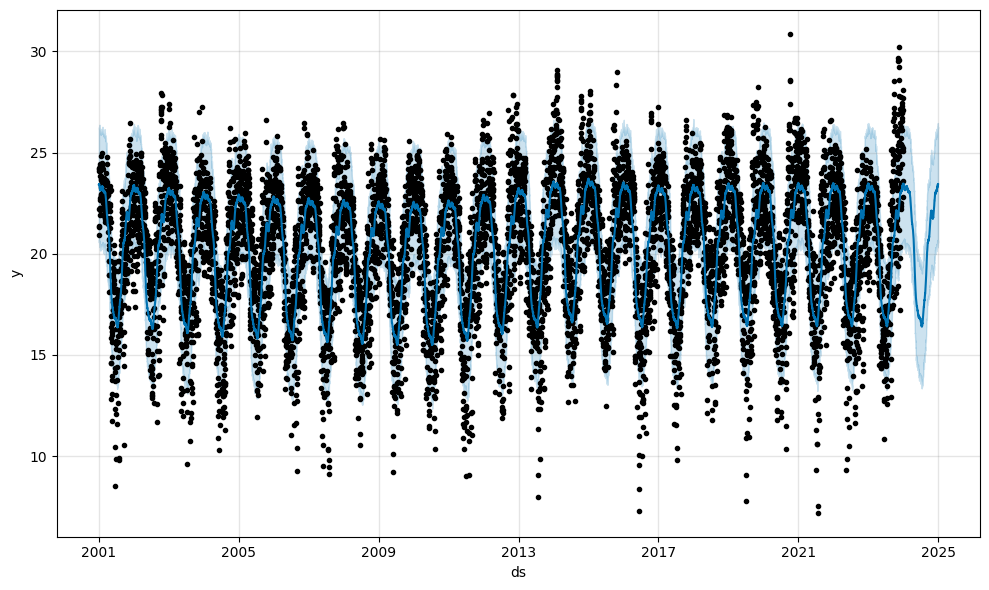

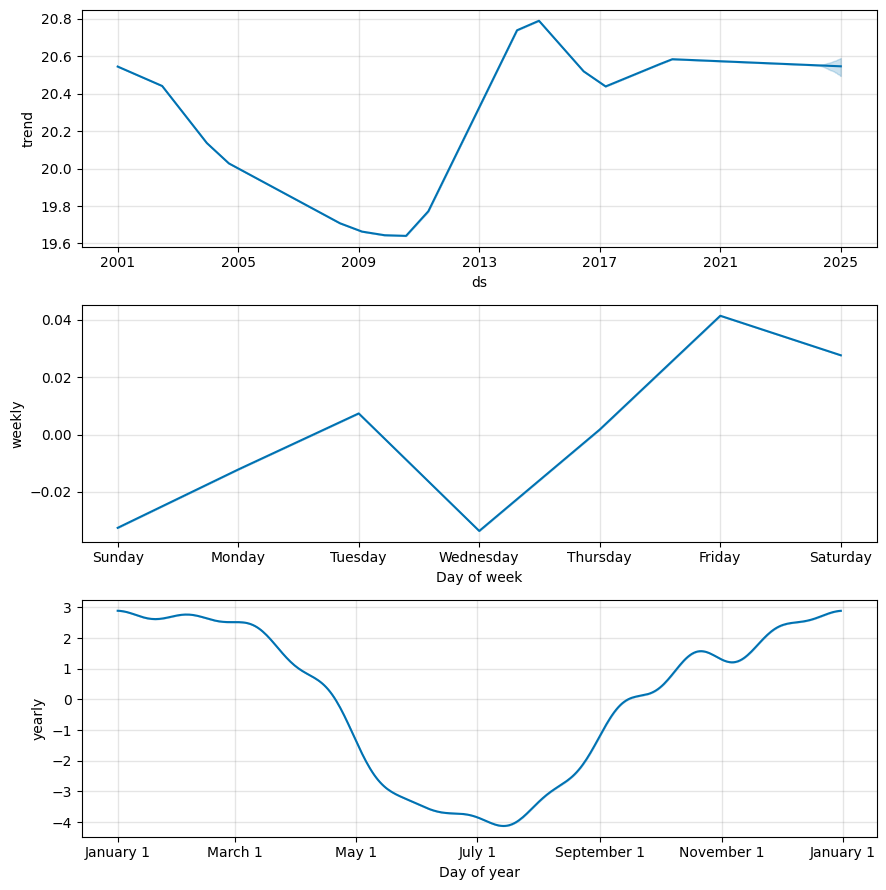

In [ ]:
import matplotlib.pyplot as plt

# Plotar a previsão
fig1 = model.plot(forecast)
plt.show()

# Plotar os componentes (tendência, sazonalidade, etc.)
fig2 = model.plot_components(forecast)
plt.show()


In [ ]:
# Filtrar previsões para 2023
forecast_2023 = forecast[forecast['ds'].dt.year == 2023]
actual_2023 = prophet_data[prophet_data['ds'].dt.year == 2023]

# Avaliar o MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual_2023['y'], forecast_2023['yhat'])
print(f"MAE para o Prophet: {mae}")


MAE para o Prophet: 1.9232282091282835
